# Project 3: Community learning
Unsupervised learning on song lyrics data acquired through [Genius API](https://docs.genius.com/) aiming to be able to predict genre of a song given lyrics.

There are $5$ main steps involved
1. [DATA ACQUISITION](#step1)
    1. Different techniques and models were explored
        * [TextHeo -> TF-IDF -> KMeans](code/Texthero_tfidf_kmeans.ipynb)
        * [Natural Language Toolkit -> CountVectorizer -> KMeans](code/CountVec_KMeans.ipynb)
        * [Gensim's word2vec -> Kmeans](code/song_gensim.ipynb)
1. [DATA CLEANING](#step2)
1. [TEXT VECTORIZATION](#step3)
    1. The best model we arrived at employes NLP sentence embedding
1. [UNSUPERVISED MODEL TRAINING](#step4)
    1. `KMeans` is used
1. [CLUSTER VISUALIZATION](#step5)
    1. 3D visualization using `UMAP` as dimensional reducer model and the scatter plot is colored based on its tag from above step

## Team Members:
1. Allistair Cunanan
1. Khanin Thongmongkol
1. Roozbeh Kargar
1. Travis Clapp

In [1]:
# importing main modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re

***
## DATA ACQUISITION <a name="step1"></a>
> First, we obtained a list of songs from https://goldstandardsonglist.com/Pages_Sort_2a/Sort_2a.htm

> Next, we use the song names to retrieve lyrics from [genius.com](https://genius.com/) through its API

In [2]:
# getting list of songs along with its genre
from bs4 import BeautifulSoup as sp
import requests

r = requests.get('https://goldstandardsonglist.com/Pages_Sort_2a/Sort_2a.htm')
soup = sp(r.text, 'html.parser')

title = [x.text.replace('\n', ' ').strip() for x in soup.find_all(class_='table1column2')]
genre = [x.text.replace('\n', ' ').strip() for x in soup.find_all(class_='table1column3')]
pd.DataFrame({'title':title, 'genre':genre}).to_csv(r'data/song_titles.csv')

In [3]:
# retrieving lyrics via genius API
# took 3 hours to retrieve lyrics, so I have commented out this part to not accidentrly run it

# uncomment this cell to run the retrieval code
'''
import lyricsgenius
CLIENT_KEY = '' # need to create an account with genius to get this key
assert len(CLIENT_KEY) > 0 # client key is needed
genius = lyricsgenius.Genius(CLIENT_KEY)

title_df = pd.read_csv(r'data/song_titles.csv', index_col=0, header='infer')
Lyrics = [None]*len(title_df)
for i in range(len(title_df)):
    # using try except to take care of those songs not avilable in the genius database
    try: 
        x = title_df.title.iloc[i]
        ly = genius.search_song(x).lyrics
        Lyrics[i] = ly
    except:
        None
title_df.append({'lyrics':Lyrics}, ignore_index=True).to_csv(r'data/song_lyrics.csv')
'''

"\nimport lyricsgenius\nCLIENT_KEY = '' # need to create an account with genius to get this key\nassert len(CLIENT_KEY) > 0 # client key is needed\ngenius = lyricsgenius.Genius(CLIENT_KEY)\n\ntitle_df = pd.read_csv(r'data/song_titles.csv', index_col=0, header='infer')\nLyrics = [None]*len(title_df)\nfor i in range(len(title_df)):\n    # using try except to take care of those songs not avilable in the genius database\n    try: \n        x = title_df.title.iloc[i]\n        ly = genius.search_song(x).lyrics\n        Lyrics[i] = ly\n    except:\n        None\ntitle_df.append({'lyrics':Lyrics}, ignore_index=True).to_csv(r'data/song_lyrics.csv')\n"

In [4]:
song = pd.read_csv(r'data/song_lyrics.csv', index_col=0, header='infer')
song = song.dropna()
song.reset_index(drop=True, inplace=True)
song

title              genre  \
0                                 Abilene  Country/Bluegrass   
1     Above And Beyond (The Call Of Love)  Country/Bluegrass   
2                           AC/DC Current               Jazz   
3                       Acadian Driftwood         Folk/Roots   
4           Ac-Cent-Tchu-Ate The Positive              Swing   
...                                   ...                ...   
4754                               Zeebob               Jazz   
4755                     Zig Zag Wanderer           Rock/Pop   
4756                       Ziggy Stardust           Rock/Pop   
4757                    Zip-A-Dee-Doo-Dah       Musical/Film   
4758                Zorba The Greek Theme         Folk/Roots   

                                                 lyrics  
0     Abilene Abilene prettiest town I've ever seen\...  
1     Well I'll give you love that's above and beyon...  
2     Y'all know me, still the same Eevee\r\nThe old...  
3     The war was over\r\nAnd the spirit was broken\...  
4     Gather 'round me, everybody\r\nGather 'round m...  
...                                                 ...  
4754  Part One Chapter 10\r\nTo Kill a Mockingbird\r...  
4755  Zig zag\r\n\r\nZig zag wanderer, zig zag wande...  
4756  Ground Control to Major Tom\r\nGround Control ...  
4757  Zip-a-dee-doo-dah\r\nZip-a-dee-yae\r\nMy, my, ...  
4758  Brewton Alabama at The Colonial Inn\r\nHot day...  

[4759 rows x 3 columns]

***
## DATA EXPLORATION AND CLEANING <a name="step2"></a>
Filtering out songs with unrelated information.

In [5]:
# Upon inspection, some songs contain unrelavant information, 
# i.e. something else that is not lyrics, which might have been 
# caused by our retirval code, API bugs or others, and these 
# songs need to be filtered out before analysis

# first, make all characteres lowercase and remove punctuations
def remove_punct(text, chop_it=False):
    newtext = text.lower()
    newtext = newtext.replace('\n', ' ')
    newtext = re.sub(r'[^\w\s]',' ',newtext)
    newtext = re.sub(r'_',' ', newtext)
    newtext = newtext.replace('  ', ' ')
    return newtext.split() if chop_it else newtext

df = song.copy()
r = []
for row in df.lyrics:
    r.append(remove_punct(row))

Text(0.5, 0, 'number of characters')

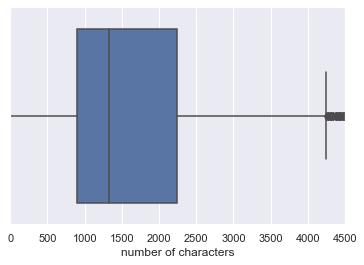

In [6]:
# from boxplot, some samples are deemed "outliers"
# we will simply remove them
r_len = [*map(len, r)]
ax = sns.boxplot(x=r_len)
ax.set_xlim([0, 4500])
ax.set_xlabel('number of characters')

In [7]:
# setting the upper bound based on boxplot 
from scipy.stats import iqr
upper = np.quantile(r_len, q=0.75) + 1.5*iqr(r_len) # getting the cutoff values
upper

4247.0

In [8]:
# an example of upper song filtered out by setting upper bound 

# data like this needs to be removed
# it contains unrelavant information 
# Bug in the API system ??
df.lyrics[df[r_len == np.max(r_len)].index[0]]

'Wage Labour and Capital\r\nKARL MARX\r\n\xa0 \xa0 \xa0 \xa0 Shortly after adumbrating the materialist conception of history in the 1844 manuscripts and formulating it comprehensively in Part I of The German Ideology, Marx turned to the economic studies that were going to preoccupy him in the ensuing years. This did not signify any change of interests or outlook but was the logical outgrowth of the position taken in his earlier writings. If the thesis on "alienated labor" was to be made scientifically cogent and if the expectation of coming proletarian revolution was to be based upon it, he needed to show the capital-labor relationship, which he took to be the core of the bourgeois socio-economic system, to be dialectically self-destructive, i.e. , transitory by virtue of its inner dynamics of development. The first work in which he attempted this analysis was Wage Labour and Capital.\r\n\xa0 \xa0 \xa0 \xa0 Having first presented it in lectures to a German workers\' society in Brussels

In [9]:
# as for lower bound, we use trial and error method
# By trial and error, 200 gives a good filter for lower bound
i = 200
while True:
    if any(np.array(r_len) == i):
        break
    i = i+1
lower = np.float64(i) # for comparison purpose in the filter 
df.lyrics[df[np.array(r_len) == i].index[0]]

'Down by the Old Mill Stream\r\nWhere I first met you\r\nWith your eyes of blue\r\nDressed in gingham too\r\nIt was there I knew\r\nThat you loved me true\r\nYou were sixteen, my village queen\r\nDown by the old mill stream!'

In [10]:
# an example of those samples below lower bound
# as can be seen here, it doesn't contain lyrics at all
df.lyrics[df[r_len == np.min(r_len)].index[0]]

'/'

In [11]:
# removing those songs with too long or short of lyrics 
reduced_df = df.iloc[(r_len >= lower) & (r_len <= upper)].reset_index(drop=True)
reduced_df

title              genre  \
0                                 Abilene  Country/Bluegrass   
1     Above And Beyond (The Call Of Love)  Country/Bluegrass   
2                           AC/DC Current               Jazz   
3                       Acadian Driftwood         Folk/Roots   
4           Ac-Cent-Tchu-Ate The Positive              Swing   
...                                   ...                ...   
4410       You've Really Got A Hold On Me         R & B/Soul   
4411                     Zig Zag Wanderer           Rock/Pop   
4412                       Ziggy Stardust           Rock/Pop   
4413                    Zip-A-Dee-Doo-Dah       Musical/Film   
4414                Zorba The Greek Theme         Folk/Roots   

                                                 lyrics  
0     Abilene Abilene prettiest town I've ever seen\...  
1     Well I'll give you love that's above and beyon...  
2     Y'all know me, still the same Eevee\r\nThe old...  
3     The war was over\r\nAnd the spirit was broken\...  
4     Gather 'round me, everybody\r\nGather 'round m...  
...                                                 ...  
4410  I don't like you\r\nBut I love you\r\nSeems th...  
4411  Zig zag\r\n\r\nZig zag wanderer, zig zag wande...  
4412  Ground Control to Major Tom\r\nGround Control ...  
4413  Zip-a-dee-doo-dah\r\nZip-a-dee-yae\r\nMy, my, ...  
4414  Brewton Alabama at The Colonial Inn\r\nHot day...  

[4415 rows x 3 columns]

In [12]:
np.array(r_len)[(r_len >= lower) & (r_len <= upper)]

array([ 444,  534, 3686, ..., 1151,  864, 1870])

***
## TEXT VECTORIZATION <a name="step3"></a>
Google sentence encoder is employed

Trained model can be obtained from https://tfhub.dev/s?module-type=text-embedding

[Reference](https://towardsdatascience.com/use-cases-of-googles-universal-sentence-encoder-in-production-dd5aaab4fc15#:%7E:text=The%20Universal%20Sentence%20Encoder%20encodes,and%20other%20natural%20language%20tasks.&text=It%20comes%20with%20two%20variations,Deep%20Averaging%20Network%20(DAN).)

In [13]:
import sys
sys.path.insert(0, 'E:\\Download\\universal-sentence-encoder') # or where ever you store the downloaded data

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
def embed_useT(module):
    with tf.Graph().as_default():
        sentences = tf.compat.v1.placeholder(tf.string)
        embed = hub.Module(module)
        embeddings = embed(sentences)
        session = tf.compat.v1.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

embed_fn = embed_useT(sys.path[0])

OSError: E:\Download\universal-sentence-encoder does not exist.

In [ ]:
# testing that the sentence encoder takes care of punctuations
messages = [
    "Women there don't treat you mean in Abilene my Abilene",
    "(Women there don't treat you mean) in Abilene my Abilene",
    '-we are sorry for the inconvenience-'
]
encoding_matrix = embed_fn(messages)
np.corrcoef(encoding_matrix)
# can see that the 1st and 2nd sentence are perfectly correlated.
# This shows that the encoder takes care of punctuations, so we
# can simply feed "dirty" sentences to the encoder

In [ ]:
# assuming that lines are separated via '\n'
lyrics = reduced_df.lyrics.apply(lambda x: x.split('\n'))
lyrics

In [ ]:
# a dictionary of word vectors, so that it can be 
# used for analysis
dict512 = {}
for i in range(len(reduced_df)):
    dict512[i] = embed_fn(lyrics[i]).sum(axis=0)
    # verifying that this currrent lyrics has vectorized properly
    if len(dict512[i]) != 512:
        assert False

In [ ]:
emb512 = pd.DataFrame.from_dict(dict512, 'index')
emb512

***
# DETERMING NUMBER OF CLUSTERS
Here we use elbow method

In [ ]:
from sklearn.cluster import KMeans

# https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
# calculate distortion for a range of number of cluster
X = emb512.values
distortions = []
k_min = 1
k_max = 40
for i in range(k_min, k_max):
    km = KMeans(
        n_clusters=i, init='random',
        max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.figure()
plt.plot(range(k_min, k_max), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()
# it seems like inflection point located in 5-10 region
# visually inspecting, k=7 seems to be a good choice
# more rigorous calculation can be employed to select the inflection
# but for faster implmenetation, visual based is employed here

***
## UNSUPERVISED MODEL TRAINING <a name="step4"></a>

In [ ]:
# kmeans with number of cluster picked via elbow method
from sklearn.cluster import KMeans
cluster_num = 7
model_kmean512 = KMeans(n_clusters=cluster_num, init='random', max_iter=300, tol=1e-04, random_state=0)
model_kmean512.fit(emb512.values)

***
## CLUSTER VISUALIZATION <a name="step5"></a>

In [ ]:
# dimensionality reduction for viz
import umap
data512 = emb512.values
# using UMAP as manifold model 
model_viz512 = umap.UMAP(n_neighbors=20, n_components=3)
reduced_emb512 = model_viz512.fit_transform(data512)

In [ ]:
plt.style.use('default')

import itertools
orientation = [*itertools.permutations([0,1,2])]


a = pd.DataFrame({'x':reduced_emb512[:,0], 
                  'y':reduced_emb512[:,1], 
                  'z':reduced_emb512[:,2], 
                  'label':model_kmean512.labels_})

filled_markers = ('v', 'o', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

for or_i in range(len(orientation)):
    plt.figure(figsize=(12,9))
    ax = plt.axes(projection = '3d')

    for i in range(model_kmean512.n_clusters):
        each = a[a.label==i][list('xyz')].values
        ax.scatter(each[:,orientation[or_i][0]],
                   each[:,orientation[or_i][1]],
                   each[:,orientation[or_i][2]], 
                   marker=filled_markers[i], label=f'{i}')

    ax.legend()
    plt.title(f'orientation: {orientation[or_i]}')
    plt.show()